# Survival Analysis of fine-tune VAE models

## libraries & functions

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt


from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

#importing fundtion to get encoder info and perfrom tasks 
from finetune.get_finetune_encoder import  get_finetune_input_data

from models.models_VAE import VAE
from pretrain.train_pretrain_VAE import PretrainVAE
from finetune.best_finetune_model_test_eval_cox import evaluate_model

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-10-07 16:46:02.148178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 16:46:02.163693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 16:46:02.183672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 16:46:02.189616: E external/local_xla/xla/stream_executor/c

CoxPHFitter	 DataLoader	 KaplanMeierFitter	 LabelEncoder	 PretrainVAE	 TensorDataset	 VAE	 accuracy_score	 evaluate_model	 
f1_score	 get_finetune_input_data	 imaplib	 importlib	 label_encoder	 logrank_test	 matplotlib	 ml_code_path	 nn	 
np	 optim	 optuna	 os	 pd	 plt	 precision_score	 random	 recall_score	 
roc_auc_score	 torch	 


In [2]:
def fit_cox_pairwise(df, group1, group2):
    """Fits a Cox proportional hazard model for two groups and returns the summary."""
    # Filter the data for only the two groups
    df_filtered = df[df['risk_group'].isin([group1, group2])].copy()
    
    # Create a binary variable for the group comparison (1 for group1, 0 for group2)
    df_filtered['group_binary'] = np.where(df_filtered['risk_group'] == group1, 1, 0)
    
    # Fit Cox proportional hazard model
    cph = CoxPHFitter()
    cph.fit(df_filtered[['durations', 'event_observed', 'group_binary']], duration_col='durations', event_col='event_observed')
    
    return cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]



## KM plots for 3 groups

In [45]:
def km_plot_cox_3_risk_groups(all_risks, all_durations, all_events, n_poor, n_favorable):
    # Convert to numpy arrays if they aren't already
    all_risks = np.array(all_risks)
    all_durations = np.array(all_durations)
    all_events = np.array(all_events)
    
    # Sort risks and split into three groups: 'Poor', 'Intermediate', 'Favorable'
    sorted_indices = np.argsort(all_risks)
    
    # Define group sizes
    poor_group_size = n_poor
    favorable_group_size = n_favorable
    
    # Get the indices for each group
    poor_indices = sorted_indices[-poor_group_size:]  # Highest 34 risks
    favorable_indices = sorted_indices[:favorable_group_size]  # Lowest 23 risks
    intermediate_indices = sorted_indices[favorable_group_size:-poor_group_size]  # Middle group

    # Create masks for each group
    poor_mask = np.isin(np.arange(len(all_risks)), poor_indices)
    favorable_mask = np.isin(np.arange(len(all_risks)), favorable_indices)
    intermediate_mask = np.isin(np.arange(len(all_risks)), intermediate_indices)

    # Count number of patients in each group
    num_poor = np.sum(poor_mask)
    num_favorable = np.sum(favorable_mask)
    num_intermediate = np.sum(intermediate_mask)

    # Initialize KaplanMeierFitter objects
    kmf_poor = KaplanMeierFitter()
    kmf_intermediate = KaplanMeierFitter()
    kmf_favorable = KaplanMeierFitter()

    # Fit each KM model
    kmf_poor.fit(all_durations[poor_mask], event_observed=all_events[poor_mask], label=f"Poor (n={num_poor})")
    kmf_intermediate.fit(all_durations[intermediate_mask], event_observed=all_events[intermediate_mask], label=f"Intermediate (n={num_intermediate})")
    kmf_favorable.fit(all_durations[favorable_mask], event_observed=all_events[favorable_mask], label=f"Favorable (n={num_favorable})")

    # Plot the KM curves with censoring marks (ticks for censoring events)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    kmf_poor.plot_survival_function(ax=ax, ci_show=False, show_censors=True, censor_styles={'ms': 7, 'marker': '|'})
    kmf_intermediate.plot_survival_function(ax=ax, ci_show=False, show_censors=True, censor_styles={'ms': 7, 'marker': '|'})
    kmf_favorable.plot_survival_function(ax=ax, ci_show=False, show_censors=True, censor_styles={'ms': 7, 'marker': '|'})

    # Add a horizontal line for OS probability of 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--')

    # Get the minimum y-axis value
    y_min, y_max = ax.get_ylim()

    # Add vertical lines for median OS for each group and annotate the values (starting from 0.5 to y_min)
    median_os_poor = kmf_poor.median_survival_time_
    median_os_intermediate = kmf_intermediate.median_survival_time_
    median_os_favorable = kmf_favorable.median_survival_time_

    # Vertical lines and annotations for each group's median OS
    if not np.isnan(median_os_poor):
        plt.plot([median_os_poor, median_os_poor], [0.5, y_min], color='blue', linestyle='--')
        plt.text(median_os_poor, 0.25, f"{median_os_poor:.1f} months", color='blue', fontsize=10, verticalalignment='bottom')
    
    if not np.isnan(median_os_intermediate):
        plt.plot([median_os_intermediate, median_os_intermediate], [0.5, y_min], color='orange', linestyle='--')
        plt.text(median_os_intermediate, 0.25, f"{median_os_intermediate:.1f} months", color='orange', fontsize=10, verticalalignment='bottom')

    if not np.isnan(median_os_favorable):
        plt.plot([median_os_favorable, median_os_favorable], [0.5, y_min], color='green', linestyle='--')
        plt.text(median_os_favorable, 0.25, f"{median_os_favorable:.1f} months", color='green', fontsize=10, verticalalignment='bottom')

    # Add median OS to the plot title
    plt.title(f"Kaplan-Meier Survival Curve: Risk Groups\n"
              f"Median OS: Poor={median_os_poor:.1f} months, Intermediate={median_os_intermediate:.1f} months, Favorable={median_os_favorable:.1f} months")
    
    # Customize plot
    plt.xlabel('Time (in months)')
    plt.ylabel('Survival Probability')
    plt.grid(False)

    # Prepare the data for Cox model and log-rank test
    df = pd.DataFrame({
        'durations': all_durations,
        'event_observed': all_events,
        'risk_group': np.where(poor_mask, 'Poor', np.where(intermediate_mask, 'Intermediate', 'Favorable'))
    })

    # Perform pairwise Cox model fits and get HR for each comparison
    hr_poor_vs_favorable = fit_cox_pairwise(df, 'Poor', 'Favorable')
    hr_poor_vs_intermediate = fit_cox_pairwise(df, 'Poor', 'Intermediate')
    hr_intermediate_favorable = fit_cox_pairwise(df, 'Intermediate', 'Favorable')

    # Perform log-rank tests for each pairwise comparison
    logrank_poor_vs_favorable = logrank_test(all_durations[poor_mask], all_durations[favorable_mask], 
                                             event_observed_A=all_events[poor_mask], event_observed_B=all_events[favorable_mask]).p_value
    logrank_poor_vs_intermediate = logrank_test(all_durations[poor_mask], all_durations[intermediate_mask], 
                                                event_observed_A=all_events[poor_mask], event_observed_B=all_events[intermediate_mask]).p_value
    logrank_intermediate_vs_favorable = logrank_test(all_durations[intermediate_mask], all_durations[favorable_mask], 
                                                     event_observed_A=all_events[intermediate_mask], event_observed_B=all_events[favorable_mask]).p_value

    # Create a pandas DataFrame for the p-values and Cox HR results
    results_df = pd.DataFrame({
        'Comparison': ['Poor vs Intermediate', 'Poor vs Favorable', 'Intermediate vs Favorable'],
        'Log-rank p-value': [logrank_poor_vs_intermediate, logrank_poor_vs_favorable, logrank_intermediate_vs_favorable],
        'HR': [hr_poor_vs_intermediate.iloc[0]['exp(coef)'], hr_poor_vs_favorable.iloc[0]['exp(coef)'], hr_intermediate_favorable.iloc[0]['exp(coef)']],
        'Lower 95% CI': [hr_poor_vs_intermediate.iloc[0]['exp(coef) lower 95%'], hr_poor_vs_favorable.iloc[0]['exp(coef) lower 95%'], hr_intermediate_favorable.iloc[0]['exp(coef) lower 95%']],
        'Upper 95% CI': [hr_poor_vs_intermediate.iloc[0]['exp(coef) upper 95%'], hr_poor_vs_favorable.iloc[0]['exp(coef) upper 95%'], hr_intermediate_favorable.iloc[0]['exp(coef) upper 95%']]
    }).set_index('Comparison')

    # Show the plot
    plt.show()

    # Return the results as a pandas DataFrame
    return results_df, plt



## KM plots for 2 gourps

In [4]:
# Define a function to plot the Kaplan-Meier curves for two risk groups
def km_plot_cox_2_risk_groups(all_risks, all_durations, all_events, risk_threshold=0):
    
    # Convert lists to numpy arrays
    all_risks = np.array(all_risks)
    all_durations = np.array(all_durations)
    all_events = np.array(all_events)

    # Separate patients into responders and non-responders
    responders_mask = all_risks < risk_threshold
    non_responders_mask = all_risks >= risk_threshold

    # Count the number of responders and non-responders
    num_responders = np.sum(responders_mask)
    num_non_responders = np.sum(non_responders_mask)

    # Create KaplanMeierFitter objects
    kmf_responders = KaplanMeierFitter()
    kmf_non_responders = KaplanMeierFitter()

    # Fit the KM model for responders
    kmf_responders.fit(all_durations[responders_mask], event_observed=all_events[responders_mask], label=f"Responders (n={num_responders})")
    median_os_responders = kmf_responders.median_survival_time_

    # Fit the KM model for non-responders
    kmf_non_responders.fit(all_durations[non_responders_mask], event_observed=all_events[non_responders_mask], label=f"Non-Responders (n={num_non_responders})")
    median_os_non_responders = kmf_non_responders.median_survival_time_

    # Perform log-rank test to get the p-value
    log_rank_result = logrank_test(all_durations[responders_mask], all_durations[non_responders_mask], 
                                event_observed_A=all_events[responders_mask], event_observed_B=all_events[non_responders_mask])
    p_value = log_rank_result.p_value

    # Plot the KM curves
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get the current axis

    kmf_responders.plot_survival_function(ax=ax, ci_show=True, show_censors=True, censor_styles={'ms': 5, 'marker': '|'})
    kmf_non_responders.plot_survival_function(ax=ax, ci_show=True, show_censors=True, censor_styles={'ms': 5, 'marker': '|'})

    # Add a horizontal line for survival probability of 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--')

    # Get the minimum y-axis value to draw vertical lines from 0.5 to the x-axis
    y_min, y_max = ax.get_ylim()

    # Find where the survival curves intersect with the 0.5 survival probability and add vertical lines
    if not np.isnan(median_os_responders):
        plt.plot([median_os_responders, median_os_responders], [0.5, y_min], color='blue', linestyle='--')
        plt.text(median_os_responders, 0.25, f"{median_os_responders:.1f} days", color='blue', fontsize=10, verticalalignment='bottom')

    if not np.isnan(median_os_non_responders):
        plt.plot([median_os_non_responders, median_os_non_responders], [0.5, y_min], color='orange', linestyle='--')
        plt.text(median_os_non_responders, 0.25, f"{median_os_non_responders:.1f} days", color='orange', fontsize=10, verticalalignment='bottom')

    # Customize the plot title with median OS and p-value in scientific notation
    plt.title(f"Kaplan-Meier Curve: Responders vs Non-Responders\n"
              f"Median OS: {median_os_responders:.2f} days (Responders), {median_os_non_responders:.2f} days (Non-Responders)\n"
              f"Log-rank p-value: {p_value:.2e}", fontsize=12)

    # Customize labels and remove grid
    plt.xlabel('Time (in months)')
    plt.ylabel('Survival Probability')
    plt.grid(False)  # Disable the grid

    plt.show()



# Loading the data and fine-tune VAE models

## input data

In [5]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_finetune_OG_split'

#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, 

((443, 2736), (443, 58), (149, 2736), (149, 58))

# Evaluating finetune VAEs in other tasks

# OS Finetune VAE

### loading fine-tune VAE models

In [6]:
finetune_save_dir='/home/leilapirhaji/finetune_unsupervised_VAE'
pretrain_model_name='pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1'
pretrain_trial_ID='143'

# name of task model was fine-tuned on
task='OS'

model_path=f'{finetune_save_dir}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}/TL_{task}_best_model_grid_search'

finetune_VAE_file=f'{model_path}/best_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

finetune_VAE_os=torch.load(finetune_VAE_file, map_location=device)
finetune_VAE_os.eval()


FineTuneCoxModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=1524, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.15000000000000002, inplace=False)
      (3): Linear(in_features=1524, out_features=850, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.15000000000000002, inplace=False)
      (6): Linear(in_features=850, out_features=850, bias=True)
    )
  )
  (cox_head): Sequential(
    (0): Linear(in_features=425, out_features=1, bias=True)
  )
)

In [7]:
# first getting the latent rep for the new database using finetune VAE
### Test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert pandas DataFrames to PyTorch tensors
X_test_tensor = torch.tensor(X_data_test.values, dtype=torch.float32).to(device)

latent_reps_test = []
for _ in range(10):  # Run multiple passes
    latent_rep = finetune_VAE_os.encoder(X_test_tensor) 
    mu=latent_rep[:, :finetune_VAE_os.latent_size]
    latent_reps_test.append(mu)

latent_rep_test_os = torch.mean(torch.stack(latent_reps_test), dim=0)


## evaluating the new dataset

## OS both

In [8]:
task='OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

# this return C index, as well as masked value for the task, as duraiton and inffered duration as all_risks, and events
metrics_test_os, all_durations_os, all_risks_os, all_events_os = evaluate_model(finetune_VAE_os, latent_rep_test_os, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_os, len(all_durations_os),  len(all_risks_os), len(all_events_os)

Test C-index: 0.6679294188017146
Fine-tuning completed.


(    C-index
 0  0.667929,
 149,
 149,
 149)

In [69]:
y_data_test['MSKCC'].value_counts()

MSKCC
INTERMEDIATE    65
FAVORABLE       53
POOR            31
Name: count, dtype: int64

In [13]:
model_path

'/home/leilapirhaji/finetune_unsupervised_VAE/pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1/trial_143/OS/TL_OS_best_model_grid_search'

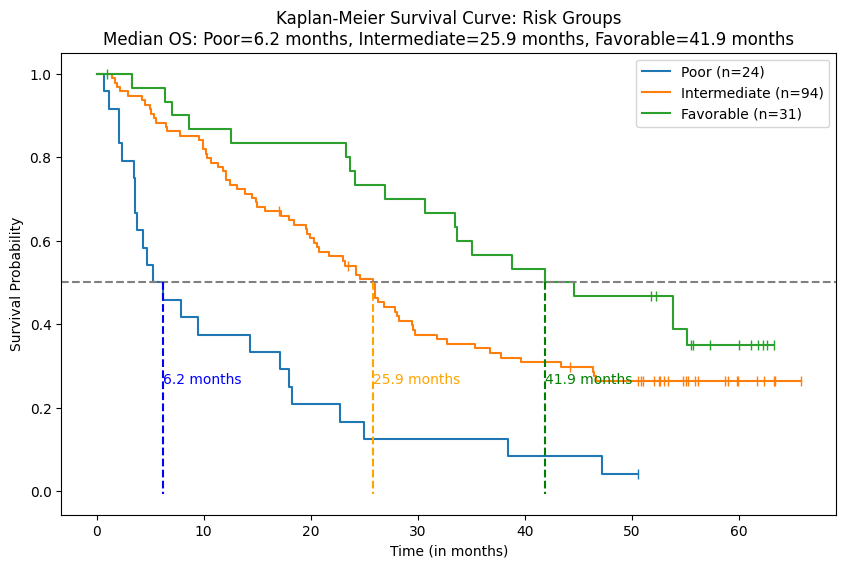

<Figure size 640x480 with 0 Axes>

In [72]:
# making 3 groups based on predicted OS and perfroing KM plot and cox model
results_os, plt = km_plot_cox_3_risk_groups(all_risks_os, all_durations_os, all_events_os, n_poor=24, n_favorable=31)
results_os['Log-rank p-value'] = results_os['Log-rank p-value'].apply(lambda x: '{:.2e}'.format(x))
plt.savefig(f'{model_path}/KM_plot_3_groups_OS_boht_vae.png')
results_os.to_csv(f'{model_path}/cox_results_3_groups_OS_both_vae.csv')

In [71]:
results_os

,Log-rank p-value,HR,Lower 95% CI,Upper 95% CI
Comparison,,,,
Poor vs Intermediate,4.46e-04,2.278385,1.421664,3.651382
Poor vs Favorable,1.67e-07,3.652324,2.182808,6.111152
Intermediate vs Favorable,1.43e-01,1.387018,0.893284,2.153647


### Filtering NAN IMDC samples

In [25]:
y_data_test['IMDC ORDINAL'].value_counts()

IMDC ORDINAL
1.0    86
0.0    34
2.0    23
Name: count, dtype: int64

In [26]:
# Convert lists to pandas Series and align the index with y_data_test
all_risks_os_series = pd.Series(all_risks_os, index=y_data_test.index)
all_durations_os_series = pd.Series(all_durations_os, index=y_data_test.index)
all_events_os_series = pd.Series(all_events_os, index=y_data_test.index)

# Create a mask to filter rows where 'IMDC' is not NaN
mask = y_data_test['IMDC ORDINAL'].notna()

# Apply the mask to filter the Series
filtered_risks_os = all_risks_os_series[mask].tolist()
filtered_durations_os = all_durations_os_series[mask].tolist()
filtered_events_os = all_events_os_series[mask].tolist()

# Now you have filtered lists
len(filtered_risks_os), len(filtered_durations_os), len(filtered_events_os)


(143, 143, 143)

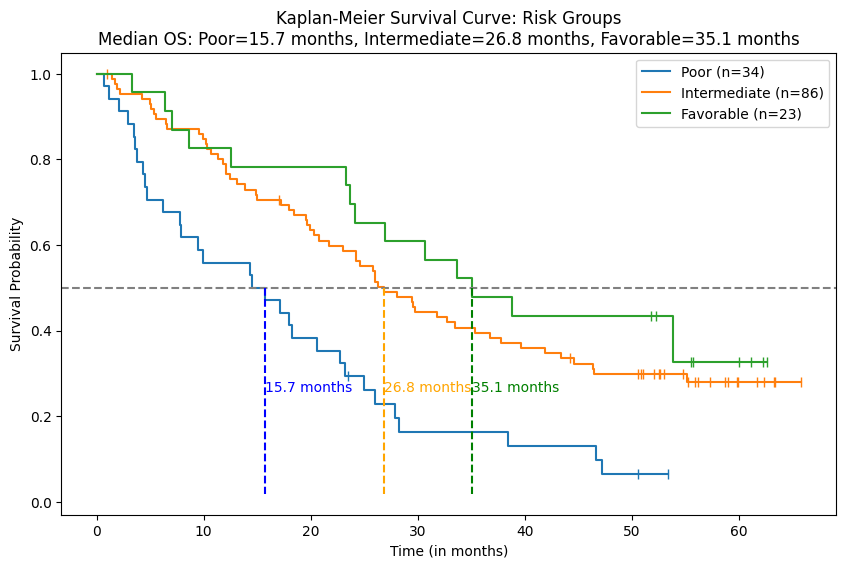

<Figure size 640x480 with 0 Axes>

In [46]:
# making 3 groups based on predicted OS and perfroing KM plot and cox model
results_os_IMDC, plt_IMDC = km_plot_cox_3_risk_groups(filtered_risks_os, filtered_durations_os, filtered_events_os, n_poor=34, n_favorable=23)
results_os_IMDC['Log-rank p-value'] = results_os_IMDC['Log-rank p-value'].apply(lambda x: '{:.2e}'.format(x))
plt.savefig(f'{model_path}/KM_plot_3_groups_OS_boht_vae_IMDC_only.png')
results_os_IMDC.to_csv(f'{model_path}/cox_results_3_groups_OS_both_vae_only.csv')

In [47]:
results_os_IMDC

,Log-rank p-value,HR,Lower 95% CI,Upper 95% CI
Comparison,,,,
Poor vs Intermediate,3.05e-04,2.206429,1.420810,3.426447
Poor vs Favorable,4.08e-04,3.131397,1.613871,6.075855
Intermediate vs Favorable,3.89e-01,1.281666,0.727311,2.258551


## NIVO using both OS finetune VAE

In [142]:
task_2='NIVO OS'
task_event='OS_Event'
y_duration_test=y_data_test[task_2]
y_event_test=y_data_test[task_event]

metrics_test_nivo_f_os, all_durations_nivo_f_os, all_risks_nivo_f_os, all_events_nivo_f_os = evaluate_model(finetune_VAE_os, latent_rep_test_os, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_nivo_f_os, len(all_durations_nivo_f_os),  len(all_events_nivo_f_os), len(all_risks_nivo_f_os)

Test C-index: 0.6918561995597946
Fine-tuning completed.


(    C-index
 0  0.691856,
 79,
 79,
 79)

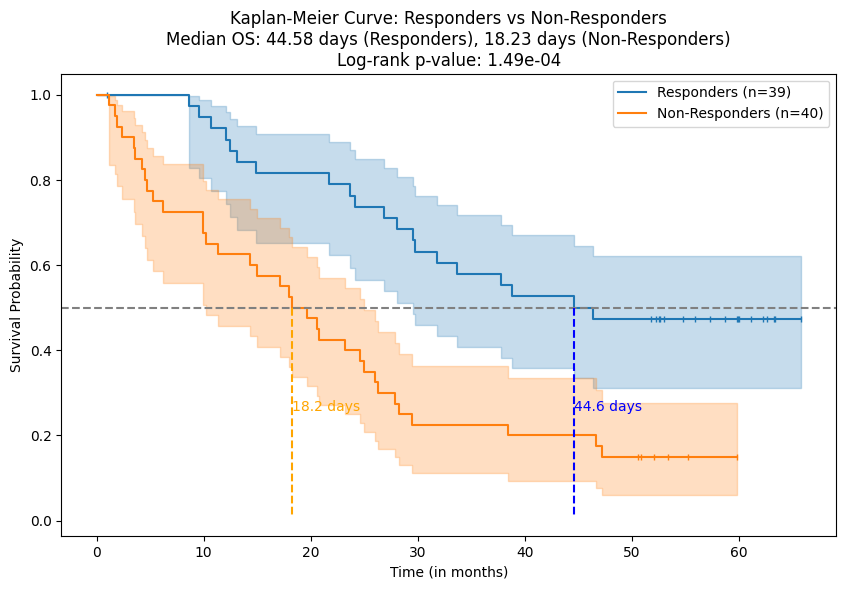

In [144]:
km_plot_cox_2_risk_groups(all_risks_nivo_f_os, all_durations_nivo_f_os, all_events_nivo_f_os, risk_threshold=np.median(all_risks_nivo_f_os))

## EVERO using both OS finetune VAE

In [145]:
task_3='EVER OS'
task_event='OS_Event'
y_duration_test=y_data_test[task_3]
y_event_test=y_data_test[task_event]

metrics_test_evero_f_os, all_durations_evero_f_os, all_risks_evero_f_os, all_events_evero_f_os = evaluate_model(finetune_VAE_os, latent_rep_test_os, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_evero_f_os, len(all_durations_evero_f_os),  len(all_events_evero_f_os), len(all_risks_evero_f_os)

Test C-index: 0.6463576158940397
Fine-tuning completed.


(    C-index
 0  0.646358,
 70,
 70,
 70)

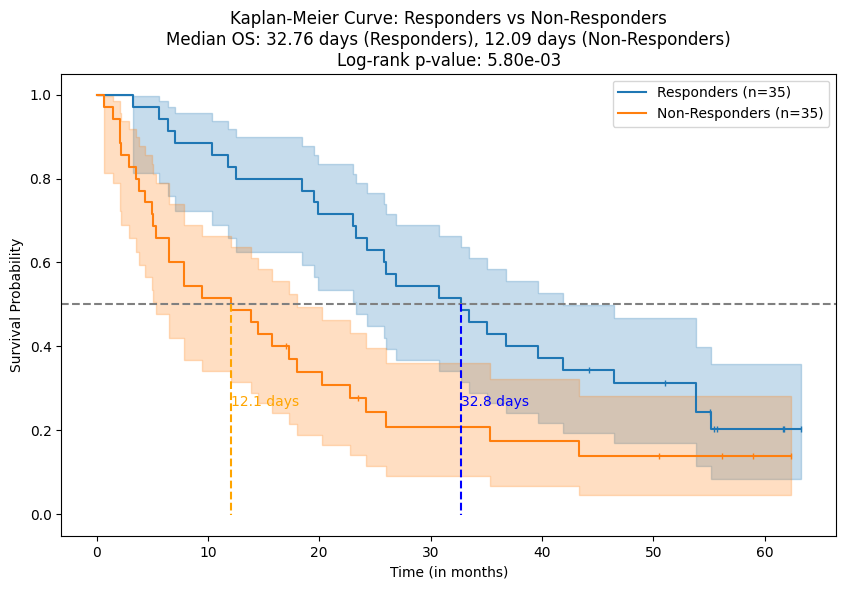

In [146]:
km_plot_cox_2_risk_groups(all_risks_evero_f_os, all_durations_evero_f_os, all_events_evero_f_os, risk_threshold=np.median(all_risks_evero_f_os))

# NIVO OS finetune VAE

### Loading the model

In [112]:
finetune_save_dir='/home/leilapirhaji/finetune_unsupervised_VAE'
pretrain_model_name='pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1'
pretrain_trial_ID='143'

# name of task model was fine-tuned on
task='NIVO_OS'

model_path=f'{finetune_save_dir}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}/TL_{task}_best_model_grid_search'

finetune_VAE_file=f'{model_path}/best_model.pth'

finetune_VAE_nivo=torch.load(finetune_VAE_file)
finetune_VAE_nivo.eval()

/var/tmp/ipykernel_365309/209794326.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_nivo=torch.load(finetune_VAE_file)


FineTuneCoxModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=1524, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.15000000000000002, inplace=False)
      (3): Linear(in_features=1524, out_features=850, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.15000000000000002, inplace=False)
      (6): Linear(in_features=850, out_features=850, bias=True)
    )
  )
  (cox_head): Sequential(
    (0): Linear(in_features=425, out_features=1, bias=True)
  )
)

In [113]:
# first getting the latent rep for the new database using finetune VAE
### Test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert pandas DataFrames to PyTorch tensors
X_test_tensor = torch.tensor(X_data_test.values, dtype=torch.float32).to(device)

latent_reps_test = []
for _ in range(10):  # Run multiple passes
    latent_rep = finetune_VAE_nivo.encoder(X_test_tensor) 
    mu=latent_rep[:, :finetune_VAE_nivo.latent_size]
    latent_reps_test.append(mu)

latent_rep_test_nivo = torch.mean(torch.stack(latent_reps_test), dim=0)

## NIVO OS finetune VAE

In [128]:
task='NIVO OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_nivo, all_durations_nivo, all_risks_nivo, all_events_nivo = evaluate_model(finetune_VAE_nivo, latent_rep_test_nivo, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_nivo

Test C-index: 0.673881144534116
Fine-tuning completed.


,C-index
0,0.673881


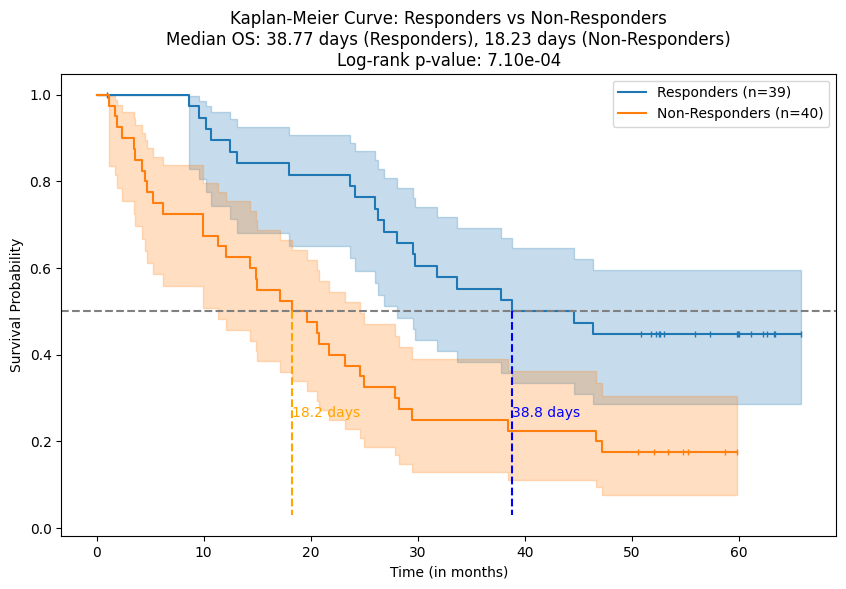

In [137]:
km_plot_cox_2_risk_groups(all_risks_nivo, all_durations_nivo, all_events_nivo, risk_threshold=np.median(all_risks_nivo))

## Evero OS on NIVO finetune VAE

In [139]:
task_3='EVER OS'
task_event='OS_Event'
y_duration_test=y_data_test[task_3]
y_event_test=y_data_test[task_event]

metrics_test_evero_f_nivo, all_durations_evero_f_nivo, all_risks_evero_f_nivo, all_events_evero_f_nivo = evaluate_model(finetune_VAE_nivo, latent_rep_test_nivo, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_evero_f_nivo

Test C-index: 0.6233995584988963
Fine-tuning completed.


,C-index
0,0.6234


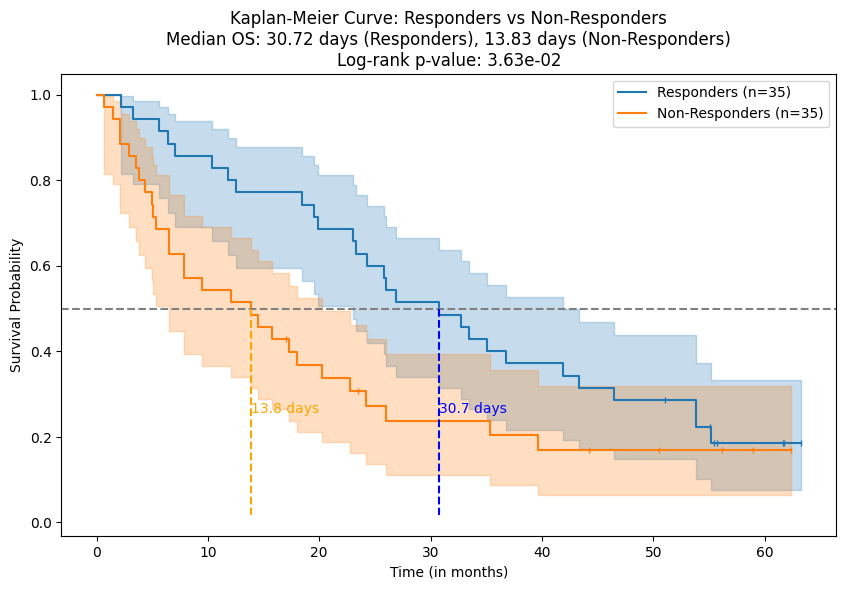

In [140]:
km_plot_cox_2_risk_groups(all_risks_evero_f_nivo, all_durations_evero_f_nivo, all_events_evero_f_nivo, risk_threshold=np.median(all_risks_evero_f_nivo))

# EVER OS finetune model

### Loading the model

In [147]:
finetune_save_dir='/home/leilapirhaji/finetune_unsupervised_VAE'
pretrain_model_name='pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1'
pretrain_trial_ID='143'

# name of task model was fine-tuned on
task='EVER_OS'

model_path=f'{finetune_save_dir}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}/TL_{task}_best_model_grid_search'

finetune_VAE_file=f'{model_path}/best_model.pth'

finetune_VAE_evero=torch.load(finetune_VAE_file)
finetune_VAE_evero.eval()
finetune_VAE_evero

/var/tmp/ipykernel_365309/2425567717.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_evero=torch.load(finetune_VAE_file)


FineTuneCoxModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=1524, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.15000000000000002, inplace=False)
      (3): Linear(in_features=1524, out_features=850, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.15000000000000002, inplace=False)
      (6): Linear(in_features=850, out_features=850, bias=True)
    )
  )
  (cox_head): Sequential(
    (0): Linear(in_features=425, out_features=1, bias=True)
  )
)

In [149]:
# first getting the latent rep for the new database using finetune VAE
### Test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert pandas DataFrames to PyTorch tensors
X_test_tensor = torch.tensor(X_data_test.values, dtype=torch.float32).to(device)

latent_reps_test = []
for _ in range(10):  # Run multiple passes
    latent_rep = finetune_VAE_evero.encoder(X_test_tensor) 
    mu=latent_rep[:, :finetune_VAE_evero.latent_size]
    latent_reps_test.append(mu)

latent_rep_test_evero = torch.mean(torch.stack(latent_reps_test), dim=0)

## Evero OS finetune VAE

In [151]:
task='EVER OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_evero, all_durations_evero, all_risks_evero, all_events_evero = evaluate_model(finetune_VAE_evero, latent_rep_test_evero, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_evero

Test C-index: 0.6582781456953642
Fine-tuning completed.


,C-index
0,0.658278


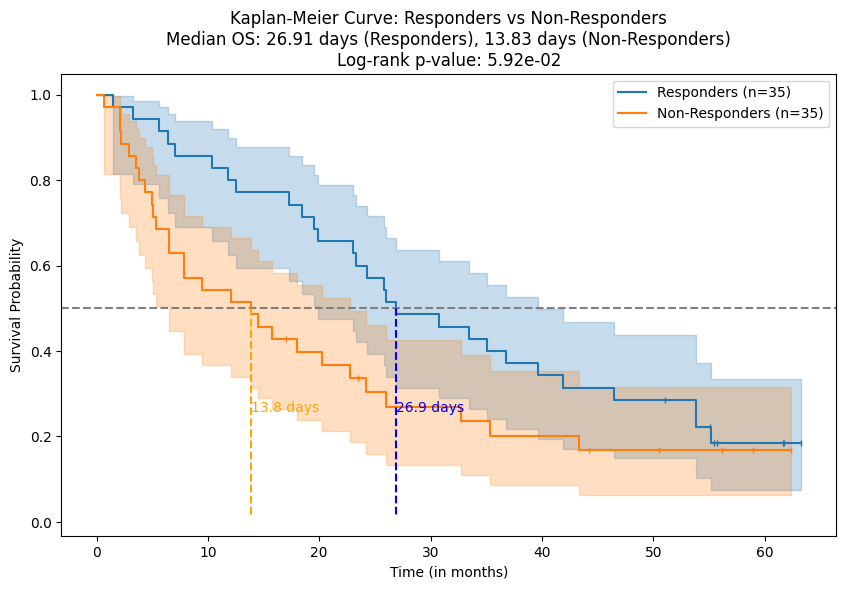

In [155]:
km_plot_cox_2_risk_groups(all_risks_evero, all_durations_evero, all_events_evero, risk_threshold=np.median(all_risks_evero))

## Nivo OS using Evero finetune VAE

In [156]:
task='NIVO OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_nivo_f_evero, all_durations_nivo_f_evero, all_risks_nivo_f_evero, all_events_nivo_f_evero = evaluate_model(finetune_VAE_evero, latent_rep_test_evero, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_nivo_f_evero

Test C-index: 0.698459280997799
Fine-tuning completed.


,C-index
0,0.698459


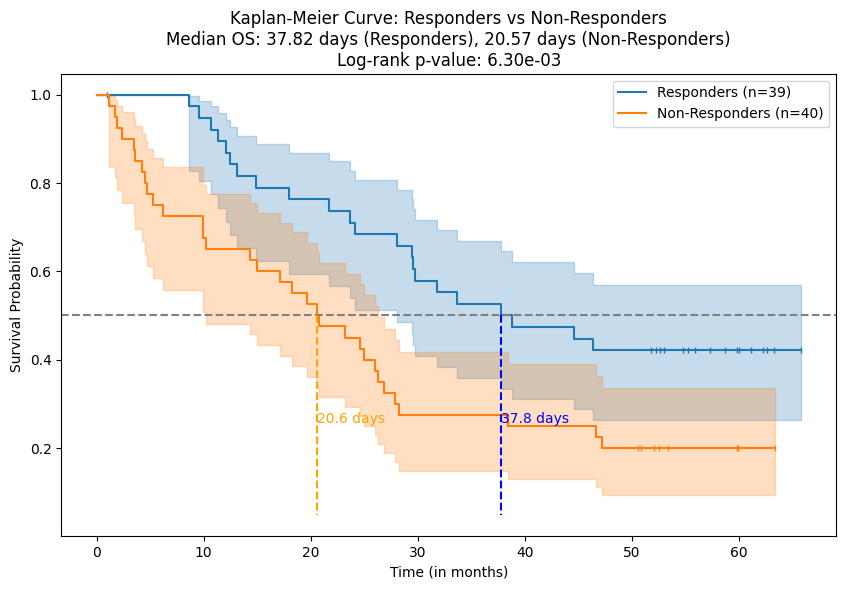

In [158]:
km_plot_cox_2_risk_groups(all_risks_nivo_f_evero, all_durations_nivo_f_evero, all_events_nivo_f_evero, risk_threshold=np.median(all_risks_nivo_f_evero))